In [5]:
import sys
sys.path.append("..")
from dataset.dataloader import MyOcrDataloader, MyCustomOcrDataloader, OCRDataAugmentor
import pandas as pd
import math
import random
import torch
import yaml
import wandb
import os
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import gc
from utils.utils import *
from utils.charactertokenizer import CharacterTokenizer
from jiwer import wer, cer
from models.models import TrOCRMyDecoder
from tqdm.auto import tqdm
from transformers import AutoTokenizer
from transformers import PreTrainedTokenizerFast

import json

In [6]:
config_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), '..')), "config/main.yaml")
with open(config_path, "r") as file:
    config = yaml.safe_load(file)
task  = config["TRAIN_TASK"]
os.environ["TOKENIZERS_PARALLELISM"] = "false"

TRAIN_PATH =config[task+"_"+"TRAIN_PATH"]
VAL_PATH =config[task+"_"+"VAL_PATH"]
IMG_ROOT = config[task+"_"+"IMG_ROOT"]

MODEL_ID = config["MODEL_ID"]

device = "cuda" if torch.cuda.is_available() else "cpu"
processor = TrOCRProcessor.from_pretrained(MODEL_ID)
# model =VisionEncoderDecoderModel.from_pretrained(MODEL_ID).to(device)
# model.config.decoder_start_token_id = processor.tokenizer.eos_token_id
# model.config.pad_token_id = processor.tokenizer.pad_token_id
# model.config.vocab_size = model.config.decoder.vocab_size

In [7]:

# tokenizer = AutoTokenizer.from_pretrained("rasyosef/bert-amharic-tokenizer")
# tokenizer.tokenize("የዓለምአቀፉ ነጻ ንግድ መስፋፋት ድህነትን ለማሸነፍ በሚደረገው ትግል አንዱ ጠቃሚ መሣሪያ ሊሆን መቻሉ ብዙ የሚነገርለት ጉዳይ ነው።")
# tokenizer.vocab_size

In [8]:
## sanity check for data loader
os.chdir("../dataset")
augmentor = OCRDataAugmentor()
# tokenizer = CharacterTokenizer.from_pretrained('/home/ubuntu/HandWritten_Amharic_English_OCR/Amharic_Char_Tokenizer2')
tokenizer = PreTrainedTokenizerFast.from_pretrained("/home/ubuntu/data/synthetic_data/amharic_tokenizer_hf")

# tokenizer = AutoTokenizer.from_pretrained("rasyosef/bert-amharic-tokenizer")

if tokenizer.bos_token_id== None:
    print("setting tokenizer")
    special_tokens_dict = {
    "bos_token": "<sos>",
    "eos_token": "<eos>"
    }
    tokenizer.add_special_tokens(special_tokens_dict)

train_data = MyCustomOcrDataloader(TRAIN_PATH, preprocessor=processor, tokenizer  = tokenizer, img_root=IMG_ROOT, transform=augmentor)
val_data = MyCustomOcrDataloader(VAL_PATH, preprocessor=processor, tokenizer  = tokenizer, img_root=IMG_ROOT)
train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['BATCH_SIZE'],
    shuffle     = True,
    collate_fn= train_data.collate_fn
    )



setting tokenizer


In [9]:

train_loader    = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config["BATCH_SIZE"],
    shuffle     = True,
    num_workers = 4,
    pin_memory  = True,
    collate_fn  = train_data.collate_fn
)

val_loader      = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = config["BATCH_SIZE"],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True,
    collate_fn  = train_data.collate_fn,
)

print("No. of Train Images   : ", train_data.__len__())
print("Batch Size           : ", config["BATCH_SIZE"])
print("Train Batches        : ", train_loader.__len__())
print("Val Batches          : ", val_loader.__len__())

No. of Train Images   :  10000
Batch Size           :  64
Train Batches        :  157
Val Batches          :  157


Checking the Shapes of the Data --



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


x_pad shape:		torch.Size([64, 1, 3, 384, 384])
x_len shape:		torch.Size([64])

y_shifted_pad shape:	torch.Size([64, 41])
y_golden_pad shape:	torch.Size([64, 41])
y_len shape:		torch.Size([64])



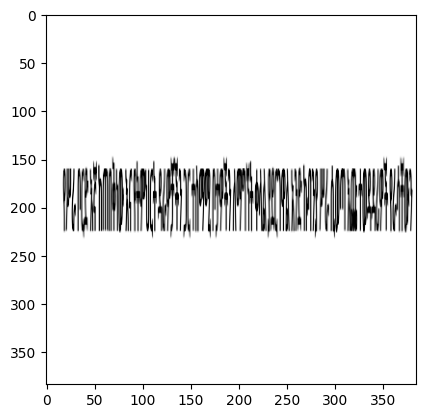

In [10]:
''' Sanity Check '''

print("Checking the Shapes of the Data --\n")

for batch in train_loader:
    x_pad, y_shifted_pad, y_golden_pad, x_len, y_len, = batch

    print(f"x_pad shape:\t\t{x_pad.shape}")
    print(f"x_len shape:\t\t{x_len.shape}\n")

    print(f"y_shifted_pad shape:\t{y_shifted_pad.shape}")
    print(f"y_golden_pad shape:\t{y_golden_pad.shape}")
    print(f"y_len shape:\t\t{y_len.shape}\n")
    plt.imshow(x_pad[0][0].permute((1,2,0)))
    # print(y_shifted_pad)

    break

In [11]:
''' Please refer to the config file and top sections to fill in the following '''

model = TrOCRMyDecoder(
input_dim                   = None,
dec_num_layers              = config["dec_num_layers"],
dec_num_heads               = config["dec_num_heads"],

d_model                     = config["d_model"],
d_ff                        = config["d_ff"],

target_vocab_size           = len(tokenizer),
eos_token                   = tokenizer.eos_token_id,
sos_token                   = tokenizer.bos_token_id,
pad_token                   = tokenizer.pad_token_id,

enc_dropout                 = config["enc_dropout"],
dec_dropout                 = config["enc_dropout"],

# decrease to a small number if you are just trying to implement the network
max_seq_length              = 512 , # Max sequence length for transcripts. Check data verification.
).to(device)

def num_parameters(mode):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params / 1E6

para = num_parameters(model)
print("#"*10)
print(f"Model Parameters:\n {para}")
print("#"*10)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.1"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_mod

##########
Model Parameters:
 109.588482
##########


In [12]:
def train_model(model, train_loader, optimizer):

    model.train()
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc="Train")

    total_loss          = 0
    running_loss        = 0.0
    running_perplexity  = 0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(train_loader):

        optimizer.zero_grad()

        inputs          = inputs.to(device)
        targets_shifted = targets_shifted.to(device)
        targets_golden  = targets_golden.to(device)

        with torch.cuda.amp.autocast():
            # passing the minibatch through the model
            # raw_predictions, attention_weights = model(inputs, inputs_lengths, targets_shifted, targets_lengths)
            raw_predictions, attention_weights = model(inputs, inputs_lengths, targets_shifted, targets_lengths)


            padding_mask = torch.logical_not(torch.eq(targets_shifted, tokenizer.pad_token_id))

            # cast the mask to float32
            padding_mask = padding_mask.float()
            loss = loss_func(raw_predictions.transpose(1,2), targets_golden)*padding_mask
            loss = loss.sum() / padding_mask.sum()

        scaler.scale(loss).backward()   # This is a replacement for loss.backward()
        scaler.step(optimizer)          # This is a replacement for optimizer.step()
        scaler.update()                 # This is something added just for FP16

        running_loss        += float(loss.item())
        perplexity          = torch.exp(loss)
        running_perplexity  += perplexity.item()

        # online training monitoring
        batch_bar.set_postfix(
            loss = "{:.04f}".format(float(running_loss / (i + 1))),
            perplexity = "{:.04f}".format(float(running_perplexity / (i + 1)))
        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()

    running_loss        = float(running_loss / len(train_loader))
    running_perplexity  = float(running_perplexity / len(train_loader))

    batch_bar.close()

    return running_loss, running_perplexity, attention_weights

In [13]:
def validate_fast(model, dataloader):
    model.eval()

    # progress bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc="Val", ncols=5)

    running_distance = 0.0
    running_cer = 0.0
    running_wer = 0.0
    running_char_f1 = 0.0
    running_word_f1 = 0.0


    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(dataloader):

        inputs  = inputs.to(device)
        targets_golden = targets_golden.to(device)

        with torch.inference_mode():
            greedy_predictions = model.recognize(inputs, inputs_lengths)

        # calculating Levenshtein Distance
        # @NOTE: modify the print_example to print more or less validation examples
        dist, cer, wer, charf1, word_f1 = calc_edit_distance(greedy_predictions, targets_golden, targets_lengths, tokenizer, print_example=True)
        running_distance += dist
        running_cer += cer
        running_wer += wer
        running_char_f1 += charf1
        running_word_f1 += word_f1


        # online validation distance monitoring
        batch_bar.set_postfix(
            running_distance = "{:.04f}".format(float(running_distance / (i + 1))),
            running_cer = "{:.04f}".format(float(running_cer / (i + 1))),
            running_wer = "{:.04f}".format(float(running_wer / (i + 1))),
            running_char_f1 = "{:.04f}".format(float(running_char_f1 / (i + 1))),
            running_word_f1 = "{:.04f}".format(float(running_word_f1 / (i + 1)))

        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()

        if i==4: break      # validating only upon first five batches

    batch_bar.close()
    running_distance /= 5
    running_cer /= 5
    running_wer /= 5
    running_char_f1 /= 5
    running_word_f1 /= 5

    return running_distance, running_cer, running_wer, running_char_f1, running_word_f1

def validate_full(model, dataloader):
    model.eval()

    # progress bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc="Val", ncols=5)

    running_distance = 0.0
    running_cer = 0.0
    running_wer = 0.0
    running_char_f1 = 0.0
    running_word_f1 =0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(dataloader):

        inputs  = inputs.to(device)
        targets_golden = targets_golden.to(device)

        with torch.inference_mode():
            greedy_predictions = model.recognize(inputs, inputs_lengths)

        # calculating Levenshtein Distance
        # @NOTE: modify the print_example to print more or less validation examples
        dist, cer, wer, charf1, word_f1 = calc_edit_distance(greedy_predictions, targets_golden, targets_lengths, tokenizer, print_example=False)
        running_distance += dist
        running_cer += cer
        running_wer += wer
        running_char_f1 += charf1
        running_word_f1 += word_f1


        # online validation distance monitoring
        batch_bar.set_postfix(
            running_distance = "{:.04f}".format(float(running_distance / (i + 1))),
            running_cer = "{:.04f}".format(float(running_cer / (i + 1))),
            running_wer = "{:.04f}".format(float(running_wer / (i + 1))),
            running_char_f1 = "{:.04f}".format(float(running_char_f1 / (i + 1))),
            running_word_f1 = "{:.04f}".format(float(running_word_f1 / (i + 1)))

        )
        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()


    batch_bar.close()
    running_distance /= len(dataloader)
    running_cer /= len(dataloader)
    running_wer /= len(dataloader)
    running_char_f1 /= len(dataloader)
    running_word_f1 /= len(dataloader)


    return running_distance, running_cer, running_wer, running_char_f1, running_word_f1

In [15]:
''' defining optimizer '''
# vocab_size = len(tokenizer)
# weights = torch.ones(vocab_size).to("cuda")  # default weight = 1 for all
# whitespace_token_id = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(' ')[0])
# # Decrease weight for whitespace token
# weights[whitespace_token_id] = 0.1  # e.g., reduce impact by 90%
loss_func   = torch.nn.CrossEntropyLoss(ignore_index = tokenizer.pad_token_id)
scaler      = torch.cuda.amp.GradScaler()
if config["optimizer"] == "SGD":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.SGD(model.parameters(),
                              lr=config["learning_rate"],
                              momentum=config["momentum"],
                              weight_decay=1E-4,
                              nesterov=config["nesterov"])

elif config["optimizer"] == "Adam":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.Adam(model.parameters(),
                               lr=float(config["learning_rate"]),
                               weight_decay=1e-4)

elif config["optimizer"] == "AdamW":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.AdamW(model.parameters(),
                                lr=float(config["learning_rate"]),
                                weight_decay=0.01)

''' defining scheduler '''

if config["scheduler"] == "ReduceLR":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                factor=config["factor"], patience=config["patience"], min_lr=1E-8, verbose=True)

elif config["scheduler"] == "CosineAnnealing":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                T_max = 35, eta_min=1E-8)

/tmp/ipykernel_710270/1907291034.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler      = torch.cuda.amp.GradScaler()


In [16]:
device

'cuda'

In [17]:
# using WandB? resume training?

USE_WANDB = config["USE_WANDB"]
RESUME_LOGGING = False

# creating your WandB run
run_name = "{}_Transformer_ENC-{}/{}_DEC-{}/{}_{}_{}_{}_{}".format(
    config["Name"],
    config["enc_num_layers"],       # only used in Part II with the Transformer Encoder
    config["enc_num_heads"],        # only used in Part II with the Transformer Encoder
    config["dec_num_layers"],
    config["dec_num_heads"],
    config["d_model"],
    config["d_ff"],
    config["optimizer"],
    config["scheduler"])
task = "handonly"

if USE_WANDB:

    wandb.login(key="3c7b273814544590b64c54d9a5242bde38616e02", relogin=True) # TODO enter your key here

    if RESUME_LOGGING:
        run_id = ""
        run = wandb.init(
            id     = run_id,        ### Insert specific run id here if you want to resume a previous run
            resume = True,          ### You need this to resume previous runs, but comment out reinit=True when using this
            project = task+"ocr-cnn-lstm",  ### Project should be created in your wandb account
        )

    else:
        run = wandb.init(
            name    = run_name,     ### Wandb creates random run names if you skip this field, we recommend you give useful names
            reinit  = True,         ### Allows reinitalizing runs when you re-run this cell
            project = task+"ocr-cnn-lstm",  ### Project should be created in your wandb account
            config  = config        ### Wandb Config for your run
        )

        ### Save your model architecture as a string with str(model)
        model_arch  = str(model)

        ### Save it in a txt file
        arch_file   = open("model_arch.txt", "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()

        ### Log it in your wandb run with wandb.save()
        # wandb.save("model_arch.txt")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ubuntu/.netrc
wandb: Currently logged in as: blessedg (idls24) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


In [18]:
e                   = 0
best_loss           = 0
best_distance  = 0
checkpoint_root = os.path.join(os.getcwd(), "checkpoints-basic-cnn-transformer")
os.makedirs(checkpoint_root, exist_ok=True)
if USE_WANDB:
    wandb.watch(model, log="all")
task =  config["TRAIN_TASK"]
checkpoint_best_loss_model_filename     = task +'checkpoint-best-loss-model.pth' 
checkpoint_best_distance_model_filename     = task +'checkpoint-best-distance-model.pth'

checkpoint_last_epoch_filename          = 'checkpoint-epoch-'
best_loss_model_path                    = os.path.join(checkpoint_root, checkpoint_best_loss_model_filename)
best_distance_model_path                    = os.path.join(checkpoint_root, checkpoint_best_distance_model_filename)


if RESUME_LOGGING:
    # change if you want to load best test model accordingly
    checkpoint = torch.load(wandb.restore(checkpoint_best_loss_model_filename, run_path=""+run_id).name)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    e = checkpoint['epoch']

    print("Resuming from epoch {}".format(e+1))
    print("Epochs left: ", config['epochs']-e)
    print("Optimizer: \n", optimizer)

torch.cuda.empty_cache()
gc.collect()

epochs = config["epochs"]
for epoch in range(e, epochs):

    print("\nEpoch {}/{}".format(epoch+1, config["epochs"]))

    curr_lr = float(optimizer.param_groups[0]["lr"])

    train_loss, train_perplexity, attention_weights = train_model(model, train_loader, optimizer)

    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Train Perplexity {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config["epochs"], train_loss, train_perplexity, curr_lr))

    if (epoch >1 )and (epoch % 10 == 0):    # validate every 2 epochs to speed up training
        levenshtein_distance, cer, wer, charf1, wordf1 = validate_fast(model, val_loader)
        if best_distance <= levenshtein_distance:
            best_distance = levenshtein_distance
            save_model(model, optimizer, scheduler, ['val_distance', levenshtein_distance], epoch, best_distance_model_path)
            # wandb.save(best_loss_model_path)
            print("Saved distance training model")
        print("Levenshtein Distance {:.04f}".format(levenshtein_distance))
        if USE_WANDB:
            wandb.log({"train_loss"     : train_loss,
                    "train_perplexity"  : train_perplexity,
                    "learning_rate"     : curr_lr,
                    "val_distance"      : levenshtein_distance,
                    "charf1": charf1,
                    "wordf1": wordf1,})

    else:
        if USE_WANDB:

            wandb.log({"train_loss"     : train_loss,
                    "train_perplexity"  : train_perplexity,
                    "learning_rate"     : curr_lr})

    # # plotting the encoder-nearest and decoder-nearest attention weights
    # attention_keys = list(attention_weights.keys())

    # attention_weights_decoder_self       = attention_weights[attention_keys[0]][0].cpu().detach().numpy()
    # attention_weights_decoder_cross      = attention_weights[attention_keys[-1]][0].cpu().detach().numpy()

    # # saving the cross-attention weights
    # save_attention_plot(attention_weights_decoder_cross, epoch+100)

    # plot_attention_weights((attention_weights[attention_keys[0]][0]).cpu().detach().numpy())
    # plot_attention_weights(attention_weights[attention_keys[-1]][0].cpu().detach().numpy())

    # if config["scheduler"] == "ReduceLR":
    #     scheduler.step(levenshtein_distance)
    # else:
    #     scheduler.step()

    # ### Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best
    # epoch_model_path = os.path.join(checkpoint_root, (checkpoint_last_epoch_filename + str(epoch) + '.pth'))
    # save_model(model, optimizer, scheduler, ['train_loss', train_loss], epoch, epoch_model_path)
    ## wandb.save(epoch_model_path) ## Can't save on wandb for all epochs, may blow up storage


    if best_loss >= train_loss:
        best_loss = train_loss
        save_model(model, optimizer, scheduler, ['train_loss', train_loss], epoch, best_loss_model_path)
        # wandb.save(best_loss_model_path)
        print("Saved best training model")

### Finish your wandb run
# run.finish()


Epoch 1/50


Train:   0%|          | 0/157 [00:00<?, ?it/s]

/tmp/ipykernel_710270/3134595652.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 1/50: 
Train Loss 9.7727	 Train Perplexity 18416.2039	 Learning Rate 0.0001

Epoch 2/50



Epoch 2/50: 
Train Loss 8.9707	 Train Perplexity 7944.8952	 Learning Rate 0.0001

Epoch 3/50



Epoch 3/50: 
Train Loss 8.6972	 Train Perplexity 5993.2762	 Learning Rate 0.0001

Epoch 4/50



Epoch 4/50: 
Train Loss 8.6477	 Train Perplexity 5703.6412	 Learning Rate 0.0001

Epoch 5/50



Epoch 5/50: 
Train Loss 8.6314	 Train Perplexity 5613.3761	 Learning Rate 0.0001

Epoch 6/50



Epoch 6/50: 
Train Loss 8.6188	 Train Perplexity 5542.7833	 Learning Rate 0.0001

Epoch 7/50



Epoch 7/50: 
Train Loss 8.6111	 Train Perplexity 5499.2242	 Learning Rate 0.0001

Epoch 8/50



Epoch 8/50: 
Train Loss 8.6051	 Train Perplexity 5467.1446	 Learning Rate 0.0001

Epoch 9/50



Epoch 9/50: 
Train Loss 8.5913	 Train Perplexity 5392.8698	 Learning Rate 0.0001

Epoch 10/50



Epoch 10/50: 
Train Loss 8.5707	 Train Perplexity 5282.2411	 Learning Rate 0.0001

Epoch 11/50



Epoch 11/50: 
Train Loss 8.5564	 Train Perplexity 5207.5053	 Learning Rate 0.0001


Val:   0%|          | 0/157 [00:00<?, ?it/s]


Ground Truth :  የፌዴራሉ ከፍተኛ ፍርድ ቤት የነ ዘላለም ወርቅ አገኘ ሁን ፍርድ ለሌላ ጊዜ አስተላለፈ
Prediction   :  


Val:   1%|▏         | 2/157 [00:58<1:15:01, 29.04s/it, running_cer=4.3790, running_char_f1=0.0529, running_distance=438.6719, running_wer=5.9513, running_word_f1=0.0074]


Ground Truth :  አንድ ኩባ ያ ም ስር የፎ ሌት ፍላ ታችንን ያ ሟ ላል
Prediction   :  


Val:   2%|▏         | 3/157 [01:26<1:13:41, 28.71s/it, running_cer=4.2833, running_char_f1=0.0532, running_distance=431.4583, running_wer=5.8157, running_word_f1=0.0066]


Ground Truth :  እሳቸው ከሥልጣን አል ወር ድም ብለው ከኢህአዴግ ጋር ሙግት ሊ ገጥ ሙ አይችሉም ይሄ ማ ውለታ ቢስ መሆን ነው እናላችሁ ሰላማዊ የስልጣን ሽግግር ከሚለው ይልቅ
Prediction   :  ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው

Val:   3%|▎         | 4/157 [01:55<1:12:51, 28.57s/it, running_cer=4.3900, running_char_f1=0.0523, running_distance=442.5898, running_wer=5.9971, running_word_f1=0.0065]


Ground Truth :  ተስፋ መፈን ጠቅ በጀመረ በት ወቅት የሚካሄድ መሆኑን በማረጋገጥ ለውጡን በብቃት ለመምራት በሚያስ ችሉ የ ድርጅትና የመንግስት ሪፎርም ጉዳዮች ዙሪያ በስፋት ተወያይቶ ውሳኔዎች አሳልፏል
Prediction   :  ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነ

Val:   3%|▎         | 5/157 [02:23<1:12:09, 28.48s/it, running_cer=4.3588, running_char_f1=0.0542, running_distance=438.9594, running_wer=5.9439, running_word_f1=0.0070]


Ground Truth :  የኢትዮጵያ የምርጫ ቅርጫ አይን ያወጣ የቅ ጥፈት የይስሙላ ምርጫ ፕሮፌሰር አለማየሁ ገብረማርያም
Prediction   :  


Saved distance training model
Levenshtein Distance 438.9594

Epoch 12/50


Train:   0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipykernel_710270/3134595652.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 12/50: 
Train Loss 8.5395	 Train Perplexity 5119.8206	 Learning Rate 0.0001

Epoch 13/50



Epoch 13/50: 
Train Loss 8.5253	 Train Perplexity 5047.4844	 Learning Rate 0.0001

Epoch 14/50



Epoch 14/50: 
Train Loss 8.5124	 Train Perplexity 4983.7845	 Learning Rate 0.0001

Epoch 15/50



Epoch 15/50: 
Train Loss 8.4974	 Train Perplexity 4908.1490	 Learning Rate 0.0001

Epoch 16/50



Epoch 16/50: 
Train Loss 8.4860	 Train Perplexity 4853.4482	 Learning Rate 0.0001

Epoch 17/50



Epoch 17/50: 
Train Loss 8.4691	 Train Perplexity 4771.8109	 Learning Rate 0.0001

Epoch 18/50



Epoch 18/50: 
Train Loss 8.4540	 Train Perplexity 4699.2930	 Learning Rate 0.0001

Epoch 19/50



Epoch 19/50: 
Train Loss 8.4417	 Train Perplexity 4644.4226	 Learning Rate 0.0001

Epoch 20/50



Epoch 20/50: 
Train Loss 8.4260	 Train Perplexity 4571.0857	 Learning Rate 0.0001

Epoch 21/50



Epoch 21/50: 
Train Loss 8.4131	 Train Perplexity 4512.3657	 Learning Rate 0.0001


Val:   1%|          | 1/157 [00:29<1:16:55, 29.58s/it, running_cer=6.4641, running_char_f1=0.0522, running_distance=652.7500, running_wer=9.7526, running_word_f1=0.0061]


Ground Truth :  የፌዴራሉ ከፍተኛ ፍርድ ቤት የነ ዘላለም ወርቅ አገኘ ሁን ፍርድ ለሌላ ጊዜ አስተላለፈ
Prediction   :  


Val:   1%|▏         | 2/157 [00:57<1:14:37, 28.89s/it, running_cer=6.3015, running_char_f1=0.0562, running_distance=630.9141, running_wer=9.2310, running_word_f1=0.0089]


Ground Truth :  አንድ ኩባ ያ ም ስር የፎ ሌት ፍላ ታችንን ያ ሟ ላል
Prediction   :  


Val:   2%|▏         | 3/157 [01:26<1:13:40, 28.71s/it, running_cer=5.9731, running_char_f1=0.0591, running_distance=597.8281, running_wer=8.7914, running_word_f1=0.0078]


Ground Truth :  እሳቸው ከሥልጣን አል ወር ድም ብለው ከኢህአዴግ ጋር ሙግት ሊ ገጥ ሙ አይችሉም ይሄ ማ ውለታ ቢስ መሆን ነው እናላችሁ ሰላማዊ የስልጣን ሽግግር ከሚለው ይልቅ
Prediction   :  ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ላይ ና ላይ ና ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነ

Val:   3%|▎         | 4/157 [01:54<1:12:52, 28.58s/it, running_cer=5.9899, running_char_f1=0.0584, running_distance=600.2773, running_wer=8.8031, running_word_f1=0.0073]


Ground Truth :  ተስፋ መፈን ጠቅ በጀመረ በት ወቅት የሚካሄድ መሆኑን በማረጋገጥ ለውጡን በብቃት ለመምራት በሚያስ ችሉ የ ድርጅትና የመንግስት ሪፎርም ጉዳዮች ዙሪያ በስፋት ተወያይቶ ውሳኔዎች አሳልፏል
Prediction   :  ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ና ና ና ና ና ላይ ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው 

Val:   3%|▎         | 5/157 [02:23<1:12:11, 28.49s/it, running_cer=6.0907, running_char_f1=0.0597, running_distance=612.2375, running_wer=8.9444, running_word_f1=0.0070]


Ground Truth :  የኢትዮጵያ የምርጫ ቅርጫ አይን ያወጣ የቅ ጥፈት የይስሙላ ምርጫ ፕሮፌሰር አለማየሁ ገብረማርያም
Prediction   :  ነው ነው ነው ነው ነው


Saved distance training model
Levenshtein Distance 612.2375

Epoch 22/50


Train:   0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipykernel_710270/3134595652.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 22/50: 
Train Loss 8.3953	 Train Perplexity 4432.8310	 Learning Rate 0.0001

Epoch 23/50



Epoch 23/50: 
Train Loss 8.3802	 Train Perplexity 4365.5502	 Learning Rate 0.0001

Epoch 24/50



Epoch 24/50: 
Train Loss 8.3677	 Train Perplexity 4311.0826	 Learning Rate 0.0001

Epoch 25/50



Epoch 25/50: 
Train Loss 8.3507	 Train Perplexity 4241.3585	 Learning Rate 0.0001

Epoch 26/50



Epoch 26/50: 
Train Loss 8.3348	 Train Perplexity 4172.2521	 Learning Rate 0.0001

Epoch 27/50



Epoch 27/50: 
Train Loss 8.3208	 Train Perplexity 4114.7990	 Learning Rate 0.0001

Epoch 28/50



Epoch 28/50: 
Train Loss 8.3055	 Train Perplexity 4052.8028	 Learning Rate 0.0001

Epoch 29/50



Epoch 29/50: 
Train Loss 8.2894	 Train Perplexity 3986.8048	 Learning Rate 0.0001

Epoch 30/50



Epoch 30/50: 
Train Loss 8.2758	 Train Perplexity 3933.2037	 Learning Rate 0.0001

Epoch 31/50



Epoch 31/50: 
Train Loss 8.2562	 Train Perplexity 3857.5520	 Learning Rate 0.0001


Val:   1%|          | 1/157 [00:29<1:17:10, 29.68s/it, running_cer=6.8331, running_char_f1=0.0556, running_distance=678.8750, running_wer=10.4767, running_word_f1=0.0030]


Ground Truth :  የፌዴራሉ ከፍተኛ ፍርድ ቤት የነ ዘላለም ወርቅ አገኘ ሁን ፍርድ ለሌላ ጊዜ አስተላለፈ
Prediction   :  


Val:   1%|▏         | 2/157 [00:58<1:14:43, 28.92s/it, running_cer=7.1421, running_char_f1=0.0630, running_distance=706.3672, running_wer=10.5578, running_word_f1=0.0059]


Ground Truth :  አንድ ኩባ ያ ም ስር የፎ ሌት ፍላ ታችንን ያ ሟ ላል
Prediction   :  


Val:   2%|▏         | 3/157 [01:26<1:13:35, 28.67s/it, running_cer=7.1433, running_char_f1=0.0636, running_distance=704.7188, running_wer=10.4846, running_word_f1=0.0066]


Ground Truth :  እሳቸው ከሥልጣን አል ወር ድም ብለው ከኢህአዴግ ጋር ሙግት ሊ ገጥ ሙ አይችሉም ይሄ ማ ውለታ ቢስ መሆን ነው እናላችሁ ሰላማዊ የስልጣን ሽግግር ከሚለው ይልቅ
Prediction   :  ነው ነው ነው ነው ነው ነው ነው ነው ነው ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው

Val:   3%|▎         | 4/157 [01:54<1:12:49, 28.56s/it, running_cer=7.2921, running_char_f1=0.0625, running_distance=720.8047, running_wer=10.6525, running_word_f1=0.0058]


Ground Truth :  ተስፋ መፈን ጠቅ በጀመረ በት ወቅት የሚካሄድ መሆኑን በማረጋገጥ ለውጡን በብቃት ለመምራት በሚያስ ችሉ የ ድርጅትና የመንግስት ሪፎርም ጉዳዮች ዙሪያ በስፋት ተወያይቶ ውሳኔዎች አሳልፏል
Prediction   :  ነው ነው ነው ነው ነው ነው ነው ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ነው ና ነው ና ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው

Val:   3%|▎         | 5/157 [02:23<1:12:16, 28.53s/it, running_cer=7.3538, running_char_f1=0.0634, running_distance=729.7875, running_wer=10.6940, running_word_f1=0.0053]


Ground Truth :  የኢትዮጵያ የምርጫ ቅርጫ አይን ያወጣ የቅ ጥፈት የይስሙላ ምርጫ ፕሮፌሰር አለማየሁ ገብረማርያም
Prediction   :  ላይ ላይ ላይ ላይ ላይ ላይ ላይ ነው


Saved distance training model
Levenshtein Distance 729.7875

Epoch 32/50


Train:   0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipykernel_710270/3134595652.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 32/50: 
Train Loss 8.2390	 Train Perplexity 3791.8289	 Learning Rate 0.0001

Epoch 33/50



Epoch 33/50: 
Train Loss 8.2193	 Train Perplexity 3716.7734	 Learning Rate 0.0001

Epoch 34/50



Epoch 34/50: 
Train Loss 8.2023	 Train Perplexity 3654.8766	 Learning Rate 0.0001

Epoch 35/50



Epoch 35/50: 
Train Loss 8.1805	 Train Perplexity 3575.5326	 Learning Rate 0.0001

Epoch 36/50



Epoch 36/50: 
Train Loss 8.1636	 Train Perplexity 3514.6354	 Learning Rate 0.0001

Epoch 37/50



Epoch 37/50: 
Train Loss 8.1423	 Train Perplexity 3441.5613	 Learning Rate 0.0001

Epoch 38/50



Epoch 38/50: 
Train Loss 8.1201	 Train Perplexity 3367.0984	 Learning Rate 0.0001

Epoch 39/50



Epoch 39/50: 
Train Loss 8.1002	 Train Perplexity 3299.2764	 Learning Rate 0.0001

Epoch 40/50



Epoch 40/50: 
Train Loss 8.0802	 Train Perplexity 3233.9039	 Learning Rate 0.0001

Epoch 41/50



Epoch 41/50: 
Train Loss 8.0587	 Train Perplexity 3165.3329	 Learning Rate 0.0001


Val:   1%|          | 1/157 [00:29<1:17:40, 29.88s/it, running_cer=6.8130, running_char_f1=0.0595, running_distance=658.6406, running_wer=11.0970, running_word_f1=0.0030]


Ground Truth :  የፌዴራሉ ከፍተኛ ፍርድ ቤት የነ ዘላለም ወርቅ አገኘ ሁን ፍርድ ለሌላ ጊዜ አስተላለፈ
Prediction   :  ነው ነው ነው ነው


Val:   1%|▏         | 2/157 [00:58<1:15:06, 29.07s/it, running_cer=6.9123, running_char_f1=0.0686, running_distance=669.7422, running_wer=10.9178, running_word_f1=0.0062]


Ground Truth :  አንድ ኩባ ያ ም ስር የፎ ሌት ፍላ ታችንን ያ ሟ ላል
Prediction   :  


Val:   2%|▏         | 3/157 [01:26<1:13:49, 28.76s/it, running_cer=7.2748, running_char_f1=0.0681, running_distance=701.3073, running_wer=11.3212, running_word_f1=0.0062]


Ground Truth :  እሳቸው ከሥልጣን አል ወር ድም ብለው ከኢህአዴግ ጋር ሙግት ሊ ገጥ ሙ አይችሉም ይሄ ማ ውለታ ቢስ መሆን ነው እናላችሁ ሰላማዊ የስልጣን ሽግግር ከሚለው ይልቅ
Prediction   :  ነው ነው ነው ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው ነው

Val:   3%|▎         | 4/157 [01:55<1:12:56, 28.61s/it, running_cer=7.4708, running_char_f1=0.0667, running_distance=721.6562, running_wer=11.4920, running_word_f1=0.0060]


Ground Truth :  ተስፋ መፈን ጠቅ በጀመረ በት ወቅት የሚካሄድ መሆኑን በማረጋገጥ ለውጡን በብቃት ለመምራት በሚያስ ችሉ የ ድርጅትና የመንግስት ሪፎርም ጉዳዮች ዙሪያ በስፋት ተወያይቶ ውሳኔዎች አሳልፏል
Prediction   :  ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና ና 

Val:   3%|▎         | 5/157 [02:23<1:12:16, 28.53s/it, running_cer=7.7097, running_char_f1=0.0690, running_distance=745.0312, running_wer=11.8044, running_word_f1=0.0067]


Ground Truth :  የኢትዮጵያ የምርጫ ቅርጫ አይን ያወጣ የቅ ጥፈት የይስሙላ ምርጫ ፕሮፌሰር አለማየሁ ገብረማርያም
Prediction   :  ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ላይ ነው


Saved distance training model
Levenshtein Distance 745.0312

Epoch 42/50


Train:   0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipykernel_710270/3134595652.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 42/50: 
Train Loss 8.0403	 Train Perplexity 3107.7294	 Learning Rate 0.0001

Epoch 43/50



Epoch 43/50: 
Train Loss 8.0187	 Train Perplexity 3040.8235	 Learning Rate 0.0001

Epoch 44/50



Epoch 44/50: 
Train Loss 7.9987	 Train Perplexity 2981.2353	 Learning Rate 0.0001

Epoch 45/50



Epoch 45/50: 
Train Loss 7.9797	 Train Perplexity 2925.8498	 Learning Rate 0.0001

Epoch 46/50



Epoch 46/50: 
Train Loss 7.9580	 Train Perplexity 2861.8200	 Learning Rate 0.0001

Epoch 47/50



Epoch 47/50: 
Train Loss 7.9370	 Train Perplexity 2802.8282	 Learning Rate 0.0001

Epoch 48/50



Epoch 48/50: 
Train Loss 7.9188	 Train Perplexity 2751.8073	 Learning Rate 0.0001

Epoch 49/50



Epoch 49/50: 
Train Loss 7.8981	 Train Perplexity 2695.9944	 Learning Rate 0.0001

Epoch 50/50



Epoch 50/50: 
Train Loss 7.8798	 Train Perplexity 2647.0547	 Learning Rate 0.0001


In [19]:
#### sweeper eval
checkpoint = torch.load(best_distance_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
result = {}
for task in ["HANDWRITTEN", "SYNTHETIC", "TYPED"]:
    print(f"{config["TRAIN_TASK"]} is been evaluated on {task}")
    VAL_PATH =config[task+"_VAL_PATH"]
    IMG_ROOT = config[task+"_IMG_ROOT"]

    val_data = MyCustomOcrDataloader(VAL_PATH, preprocessor=processor, tokenizer  = tokenizer, img_root=IMG_ROOT)
    val_loader      = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = config["BATCH_SIZE"],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True,
    collate_fn  = train_data.collate_fn,
    )
    levenshtein_distance, cer, wer, charf1, wordf1 = validate_full(model, val_loader)
    result[task]  = {}
    for metric, score in zip (["lev", "cer", "wer", "charf1", "wordf1"], [levenshtein_distance, cer, wer, charf1, wordf1]):
        result[task][metric] = score

    with open(f"result{config["TRAIN_TASK"]}_.json", 'w') as file:
        json.dump(result, file, indent=4)

SYNTHETIC is been evaluated on HANDWRITTEN


Val:  18%|█▊        | 28/157 [13:19<1:01:20, 28.53s/it, running_cer=5.1544, running_char_f1=0.0874, running_distance=306.2902, running_wer=6.9777, running_word_f1=0.0067]

KeyboardInterrupt: 